In [2]:
import numpy as np
import torchvision
import torchio as tio
from skimage.registration import optical_flow_ilk
from skimage.registration import optical_flow_tvl1
from skimage.transform import warp
import SimpleITK as sitk
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/home/raecker1/3DSSL/")
from selfsupervised2d.simclr.dataset import NakoIQADataset

/opt/conda/raecker1/envs/iqa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset

In [3]:
def load_slice_nako(subj_idx, idx, noise=None):
    if noise:
        slc = noise(nako_iqa_dataset[subj_idx])["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
    else:
        slc = nako_iqa_dataset[subj_idx]["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
        
    print(slc.shape)
    slc = torchvision.transforms.functional.resize(slc, [224, 224])
    #slc = np.pad(slice, ((0,0), (28,28)))
    #slc = torch.from_numpy(slice)
    return slc

def load_slice_nako_deep(subj_idx, idx, noise=None):
    if noise:
        slc = noise(nako_iqa_dataset_deep[subj_idx])["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
    else:
        slc = nako_iqa_dataset_deep[subj_idx]["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
        
    print(slc.shape)
    slc = torchvision.transforms.functional.resize(slc, [224, 224])
    #slc = np.pad(slice, ((0,0), (28,28)))
    #slc = torch.from_numpy(slice)
    return slc


preprocessings = tio.transforms.Compose([
            tio.transforms.ZNormalization(),
            tio.RescaleIntensity((-1, 1))
        ])

nako_iqa_dataset = NakoIQADataset("/home/raecker1/data/NAKO_IQA/NAKO_IQA_nifti/", preprocessings, suffix="bh_W_COMPOSED")
nako_iqa_dataset_deep = NakoIQADataset("/home/raecker1/data/NAKO_IQA/NAKO_IQA_nifti/", preprocessings, suffix="fb_deep_W_COMPOSED")

100%|██████████| 19/19 [00:00<00:00, 456.25it/s]


Warping

In [4]:
def warp_2D(img, flow):
    flow = flow.astype('float32')
    height, width = np.shape(img)[0], np.shape(img)[1]
    posx, posy = np.mgrid[:height, :width]
    # flow=np.reshape(flow, [-1, 3])
    vx = flow[:, :, 1]  # to make it consistent as in matlab, ux in python is uy in matlab
    vy = flow[:, :, 0]
    coord_x = posx + vx
    coord_y = posy + vy
    coords = np.array([coord_x, coord_y])
    if img.dtype == np.complex128:
        img_real = np.real(img).astype('float32')
        img_imag = np.imag(img).astype('float32')
        warped_real = warp(img_real, coords, order=1)
        warped_imag = warp(img_imag, coords, order=1)
        warped = warped_real + 1j*warped_imag
    else:
        img = img.astype('float32')
        warped = warp(img, coords, order=1)  # order=1 for bi-linear

    return warped

Cubic B-Spline Registration

In [5]:
def bspline_registration(img_fixed, img_moving):
    def command_iteration(method):
        print(
            f"{method.GetOptimizerIteration():3} "
            + f"= {method.GetMetricValue():10.5f} "
            + f": {method.GetOptimizerPosition()}"
        )

    def command_multi_iteration(method):
        print("--------- Resolution Changing ---------")

    fixed = sitk.GetImageFromArray(img_fixed)
    moving = sitk.GetImageFromArray(img_moving)

    transformDomainMeshSize = [10] * moving.GetDimension()
    tx = sitk.BSplineTransformInitializer(fixed, transformDomainMeshSize)

    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsMeanSquares()
    R.SetOptimizerAsRegularStepGradientDescent(4.0, 0.01, 200)
    R.SetOptimizerScalesFromPhysicalShift()
    R.SetInitialTransform(tx) # sitk.TranslationTransform(fixed.GetDimension())
    R.SetInterpolator(sitk.sitkLinear)
    R.SetShrinkFactorsPerLevel([6, 2, 1])
    R.SetSmoothingSigmasPerLevel([6, 2, 1])

    R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
    R.AddCommand(
        sitk.sitkMultiResolutionIterationEvent, lambda: command_multi_iteration(R)
    )

    outTx = R.Execute(fixed, moving)

    print("-------")
    print(outTx)
    print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
    print(f" Iteration: {R.GetOptimizerIteration()}")
    print(f" Metric value: {R.GetMetricValue()}")

    outFlow = sitk.TransformToDisplacementField(outTx,
                                    sitk.sitkVectorFloat64,
                                    fixed.GetSize(),
                                    fixed.GetOrigin(),
                                    fixed.GetSpacing(),
                                    fixed.GetDirection())

    outFlow_np = sitk.GetArrayFromImage(outFlow)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(outTx)
    warped = resampler.Execute(moving)
    warped_np = sitk.GetArrayFromImage(warped)

    # composing in sitk
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(warped), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)
    cimg_np = sitk.GetArrayFromImage(cimg)
    return outFlow_np, warped_np


Plots

In [6]:
def make_colorwheel():
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi

    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0

    for i in range(colorwheel.shape[1]):

        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1

        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:, :, ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''

    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)


def plot_flow(flow_uv, title='', clip_flow=None, convert_to_bgr=False, figsize=None):
    # flow_uv           [H,W,2] or list of 2D flow components [ux, uy]
    # title             string, list of strings
    # clip_flow         float, maximum clipping value for flow
    # convert_to_bgr    bool, whether to change ordering and output BGR instead of RGB
    # figsize           tuple, figure size (width, height)
    if isinstance(flow_uv, list):
        flow_uv = np.stack(flow_uv, axis=-1)

    Nmax = 8
    if len(np.shape(flow_uv)) > 3:
        M = int(np.ceil(np.shape(flow_uv)[-1] / Nmax))
        if M > 1:
            N = int(Nmax)
        else:
            N = int(np.shape(flow_uv)[-1])
    else:
        M = 1
        N = 1
    figsize = (10, 10) if figsize is None else figsize
    fig = plt.figure(figsize=figsize)
    for idx in range(M * N):
        ax = fig.add_subplot(M, N, idx + 1)
        if isinstance(title, list):
            ax.set_title(title[idx])
        else:
            ax.set_title(title)
        ax.axis('off')
        ax.set_aspect('equal')
        if len(np.shape(flow_uv)) > 3:
            flow_uv_ = flow_uv[:, :, :, idx]
        else:
            flow_uv_ = flow_uv
        if clip_flow is not None:
            flow_uv_ = np.clip(flow_uv_, 0, clip_flow)
        flow_img = flow_to_color(flow_uv_, clip_flow, convert_to_bgr)
        ax.imshow(flow_img)

torch.Size([1, 280, 224])
(224, 224)
torch.Size([1, 280, 224])
(224, 224)
--------- Resolution Changing ---------
  0 =    0.00327 : (-1.2098812914385309e-08, -1.2696082092836093e-05, -0.010796524071666662, -0.06782145113600788, 0.02043805521686069, 0.03586198891454081, 0.004716654365774263, 0.0030630682357798466, 0.004954511951312222, 0.001278676103066288, 4.2650513085078717e-05, 4.88906469333596e-07, 2.1854458464405538e-09, -8.243523662326247e-08, -0.000184443222035389, -0.16712271784841684, -0.8474874466877335, 0.33889713148432316, 0.351496718828384, 0.03923963068099675, 0.04006837656323318, 0.11132760007566547, 0.05953176428735196, 0.005217974715492133, 3.151949556259527e-05, 2.8497796903397745e-08, 1.2845736982764416e-07, 0.000163168589904674, -0.15908032440180409, -0.6824857141061709, 0.6297150656787496, 0.3361632731253362, -0.0031232199033537212, 0.07442435813498613, 0.4228242750520863, 0.3850605391887642, 0.06485553221049574, 0.0008545750685305843, 6.660665589402515e-08, 4.2008

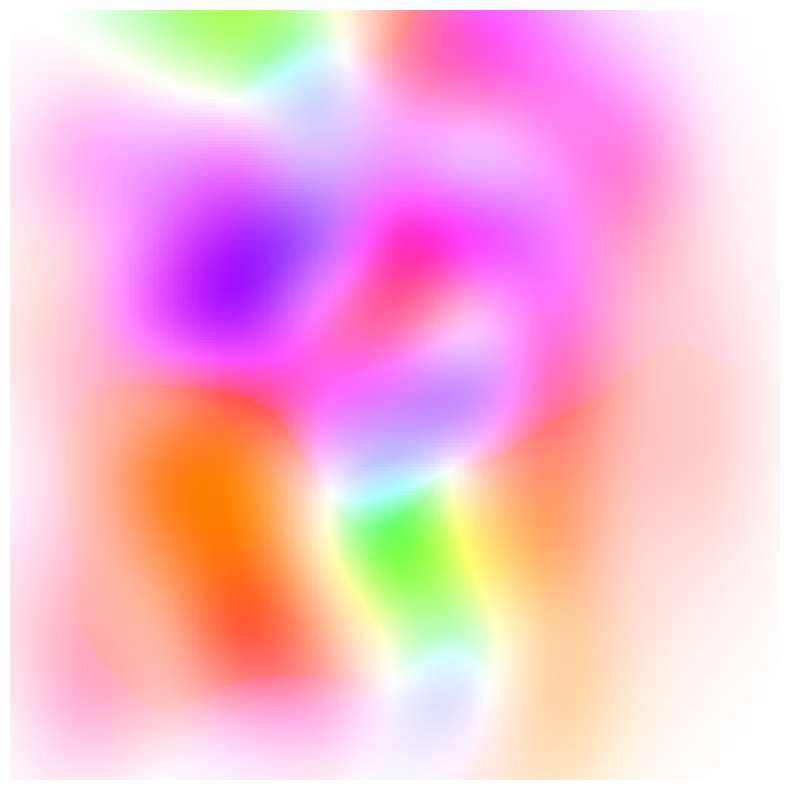

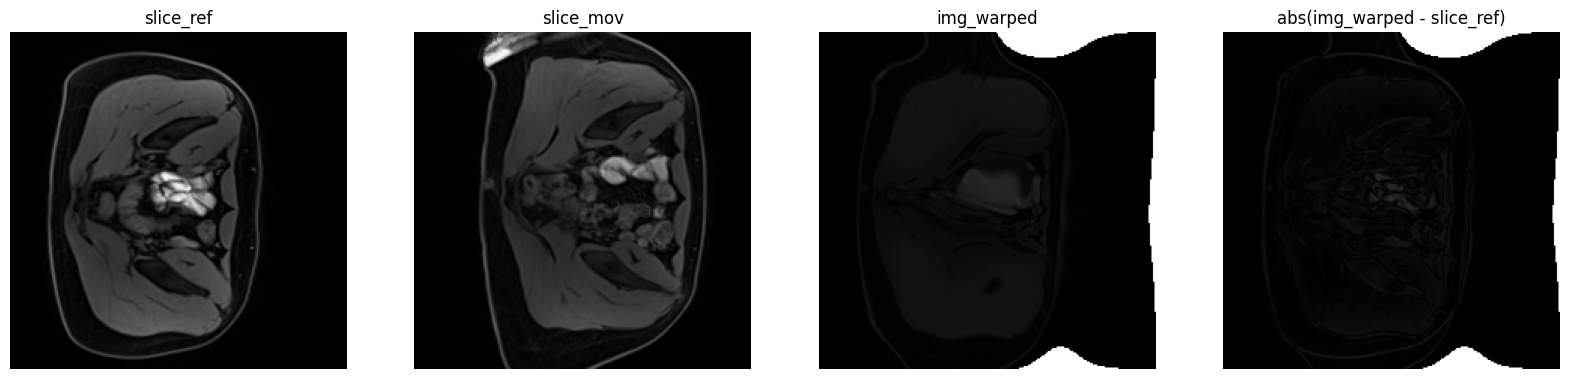

In [8]:
idx_ref = 4
idx_mov = 8
slc = 50
reg = 'bspline'

if reg == 'tvl1':
    flow = optical_flow_tvl1
elif reg == 'ilk':
    flow = optical_flow_ilk
elif reg == 'bspline':
    flow = bspline_registration
else:
    raise ValueError("Unknown registration method")

slice_ref = load_slice_nako(idx_ref, slc).numpy()
slice_ref = np.squeeze(slice_ref)
print(slice_ref.shape)

slice_mov = load_slice_nako(idx_mov, slc).numpy()
slice_mov = np.squeeze(slice_mov)
print(slice_mov.shape)

#slice_mov = load_slice_nako_deep(idx, slc)

if reg == 'bspline':
    flows, img_warped = flow(slice_ref, slice_mov)
else:
    ux, uy = flow(slice_ref, slice_mov)
    flows = np.stack([ux, uy], axis=-1)

    img_warped = warp_2D(slice_mov, flows)

# Plot results
plot_flow(flows)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot slice_ref
axs[0].imshow(slice_ref, cmap='gray')
axs[0].set_title('slice_ref')
axs[0].axis('off')

# Plot slice_mov
axs[1].imshow(slice_mov, cmap='gray')
axs[1].set_title('slice_mov')
axs[1].axis('off')

# Plot img_warped
axs[2].imshow(img_warped, cmap='gray')
axs[2].set_title('img_warped')
axs[2].axis('off')

# Plot absolute difference between img_warped and slice_ref
axs[3].imshow(np.abs(img_warped - slice_ref), cmap='gray')
axs[3].set_title('abs(img_warped - slice_ref)')
axs[3].axis('off')

plt.show()
